# Assessment of Tree Detection, Classification, and Geolocation Model
# Density Experiment - Match Predicted Trees to Tree Inventories and Compute RMSE Between Matches

Thomas Lake, December 2024


In [2]:
# Imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import geopandas as gpd
from geopy.distance import geodesic
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


In [3]:
# Load datasets: Geolocated trees, Panoramic images, Inventory Trees, and Sampling Grids0

In [4]:
# Define city for analyses
city = "NewYork"

In [5]:

# Import .CSV File for Geolocated Trees from Model
geolocated_trees = f"C:/Users/talake2/Desktop/tree-geolocation-exp/{city}_geolocation/tree_geolocation_filtered_results_{city}.csv"
geolocated_trees = pd.read_csv(geolocated_trees)

# Convert geolocated trees into a geodataframe
geometry = [Point(xy) for xy in zip(geolocated_trees['longitude'],  geolocated_trees['latitude'])]
geolocated_trees_gdf = gpd.GeoDataFrame(geolocated_trees, geometry=geometry, crs="EPSG:4326")


In [6]:
geolocated_trees_gdf.head()

,Intersection,Pano_ID_1,Pano_Origin_Lon_1,Pano_Origin_Lat_1,Est_Depth_1,Pano_ID_2,Pano_Origin_Lon_2,Pano_Origin_Lat_2,Est_Depth_2,abies_prob,...,triadica_prob,tristaniopsis_prob,tsuga_prob,ulmus_prob,washingtonia_prob,zelkova_prob,geometry,predicted_genus,latitude,longitude
0,POINT (-73.93517987913006 40.590911855231305),zzOcLRuHPHeH01Fnqzc_3g,-73.943825,40.579419,8.498084,vSr51ePnP0Vzua_uI08DhQ,-74.229551,40.527954,13.663350,0.000343,...,0.000249,0.000225,0.000120,0.000926,0.000801,0.000177,POINT (-73.93518 40.59091),quercus,40.590912,-73.935180
1,POINT (-73.94616131941794 40.58137901174476),zZMy9677FhDh91-FTkONSQ,-73.985668,40.597985,19.601303,jLpHQq95OHUVaOVrzWuulA,-73.816089,40.587086,14.771361,0.001427,...,0.000611,0.000409,0.000187,0.005240,0.018813,0.001250,POINT (-73.94616 40.58138),ailanthus,40.581379,-73.946161
2,POINT (-73.94620367990638 40.58152712972412),zZMy9677FhDh91-FTkONSQ,-73.985668,40.597985,19.601303,4uTErmdKLmdggTAQGhhZYA,-74.208811,40.557323,12.098857,0.000426,...,0.001850,0.000168,0.000166,0.007431,0.018617,0.000839,POINT (-73.94620 40.58153),styphnolobium,40.581527,-73.946204
3,POINT (-73.94621163269852 40.581554937512635),zZMy9677FhDh91-FTkONSQ,-73.985668,40.597985,19.601303,Qm7TVR6TSciq1_9_6CcrBA,-73.803521,40.590635,15.859946,0.000439,...,0.000247,0.000561,0.000222,0.004381,0.019941,0.000778,POINT (-73.94621 40.58155),ailanthus,40.581555,-73.946212
4,POINT (-73.94639496130642 40.58157430975035),z-yOpl9mO6BNsQyNubiZNg,-74.124270,40.557699,11.528285,EAC-3hLItH7U3hXrT7D2Sw,-74.069016,40.589823,5.547687,0.001423,...,0.000827,0.000740,0.000419,0.013597,0.001773,0.001242,POINT (-73.94639 40.58157),pyrus,40.581574,-73.946395


In [7]:

# Import .CSV File for Panoramic Image Locations from 'initial geolocation' file
panos = f"C:/Users/talake2/Desktop/tree-geolocation-exp/{city}_geolocation/tree_geolocation_initial_results_{city}.csv"
panos = pd.read_csv(panos)

# Define the bounding box of panoramic images for analysis
bbox = [
    panos['Pano_Origin_Lon'].min() - 0.0003,
    panos['Pano_Origin_Lon'].max() + 0.0003,
    panos['Pano_Origin_Lat'].min() - 0.0003, 
    panos['Pano_Origin_Lat'].max() + 0.0003
]

# Convert panos into a geodataframe
geometry = [Point(xy) for xy in zip(panos['Pano_Origin_Lon'],  panos['Pano_Origin_Lat'])]
panos_gdf = gpd.GeoDataFrame(panos, geometry=geometry, crs="EPSG:4326")


In [8]:
panos_gdf.head()

,Pano_ID,Pano_Origin_Lon,Pano_Origin_Lat,Est_Tree_Lon,Est_Tree_Lat,Predicted_Genus,Pano_Tree_Angle,Est_Depth,Bbox_Area,Bbox_Aspect,...,taxus_prob,thuja_prob,tilia_prob,triadica_prob,tristaniopsis_prob,tsuga_prob,ulmus_prob,washingtonia_prob,zelkova_prob,geometry
0,zzOcLRuHPHeH01Fnqzc_3g,-73.943825,40.579419,-73.943906,40.579406,gymnocladus,257.442039,7.013004,5.466672e+07,1.853958,...,0.000387,0.000418,0.001841,0.000110,0.001323,0.000555,0.006594,0.001067,0.000140,POINT (-73.94383 40.57942)
1,zzOcLRuHPHeH01Fnqzc_3g,-73.943825,40.579419,-73.943920,40.579445,gleditsia,289.954199,8.498084,9.181242e+06,0.803841,...,0.000553,0.000478,0.000674,0.000385,0.000411,0.000147,0.000235,0.001244,0.000222,POINT (-73.94383 40.57942)
2,zzOcLRuHPHeH01Fnqzc_3g,-73.943825,40.579419,-73.943907,40.579385,gleditsia,240.985163,7.888626,6.117818e+06,0.927090,...,0.000560,0.000199,0.001695,0.000512,0.000483,0.000298,0.000489,0.000749,0.000778,POINT (-73.94383 40.57942)
3,zZMy9677FhDh91-FTkONSQ,-73.985668,40.597985,-73.985547,40.598144,pyrus,30.147452,20.383770,8.782519e+05,1.252034,...,0.000060,0.000122,0.003436,0.002455,0.001179,0.000019,0.000486,0.001131,0.000523,POINT (-73.98567 40.59799)
4,zZMy9677FhDh91-FTkONSQ,-73.985668,40.597985,-73.985469,40.597963,zelkova,98.449846,17.014941,6.432887e+05,0.832827,...,0.000710,0.000261,0.003266,0.000101,0.000059,0.000110,0.006086,0.001604,0.757125,POINT (-73.98567 40.59799)


In [9]:

# Import .CSV File for Tree Inventory from Autoarborist filtered by the density sampling grids
inventory_trees = f"C:/Users/talake2/Desktop/tree-geolocation-exp/sampled_density_grids_autoarborist_join_inventory_cities/aa_100genera/{city}_aa_100genera_merged_w_sampledgrids.csv"
tree_inventory = pd.read_csv(inventory_trees)

# Convert tree_inventory to a geodataframe
geometry = [Point(xy) for xy in zip(tree_inventory['longitude'],  tree_inventory['latitude'])]
tree_inventory_gdf = gpd.GeoDataFrame(tree_inventory, geometry=geometry, crs="EPSG:4326")

# Subset tree_inventory by the bounding box
#xmin, xmax, ymin, ymax = bbox
#tree_inventory_gdf = tree_inventory_gdf.cx[xmin:xmax, ymin:ymax]

#drop_cols = ['genus label', 'capture time street img', 'tree center x street img', 'tree center y street img']
#tree_inventory_gdf = tree_inventory_gdf.drop(columns = drop_cols)

# Output basic summary statistics of dataset
print(f'There are {tree_inventory_gdf.shape[0]} trees in the {city} inventory and {geolocated_trees_gdf.shape[0]} predicted trees')


There are 6049 trees in the NewYork inventory and 27716 predicted trees


In [10]:
tree_inventory_gdf.head()

,tree id,tree location idx,city,latitude,longitude,genus,genus label,capture time street img,tree center x street img,tree center y street img,dataset type,id.y,test_tree_count,full_tree_count,density_level,grid_id,geometry
0,5434437443565017617,65cf98ee-0c5d-11ec-8a4e-23392b276719,newyork,40.593690,-73.797264,ulmus,313,July 2019,489,576,test,16,20,20,High Density,600,POINT (-73.79726 40.59369)
1,15748150470268101794,4aca61be-0c5d-11ec-8a4e-23392b276719,newyork,40.538834,-74.203316,fraxinus,127,August 2018,458,576,test,25,10,10,Medium Density,416,POINT (-74.20332 40.53883)
2,8283488947026567864,50cb7364-0c5d-11ec-8a4e-23392b276719,newyork,40.572100,-73.860730,fraxinus,127,August 2019,346,576,test,28,11,12,Medium Density,396,POINT (-73.86073 40.57210)
3,11818088767859587423,7371ac8a-0c5d-11ec-8a4e-23392b276719,newyork,40.572960,-74.141136,liriodendron,171,June 2018,340,576,test,29,5,5,Low Density,48,POINT (-74.14114 40.57296)
4,342203143948321408,5ae32f4a-0c5d-11ec-8a4e-23392b276719,newyork,40.543130,-74.162920,zelkova,324,September 2019,492,576,test,31,8,8,Medium Density,336,POINT (-74.16292 40.54313)


In [11]:

# Import City Grid Polygons Sampled for Tree Inventories Based on Density Quantiles
sampled_grids = f"C:/Users/talake2/Desktop/tree-geolocation-exp/output_grids_sampled_tree_inventories_density/sampled_grids/{city}_sampled_grid.geojson"

# Read the GeoJSON file with sampled grids
sampled_grids_gdf = gpd.read_file(sampled_grids)

# Convert to EPSG 4326 CRS
sampled_grids_gdf = sampled_grids_gdf.to_crs("EPSG:4326")

# Check the first few rows of the GeoDataFrame
print(sampled_grids_gdf.tail())

# Get information on one sampled grid
#sampled_grids_gdf.iloc[0]
sampled_grids_gdf.iloc[0].geometry.bounds


     test_tree_count  full_tree_count density_level  \
622               18               18  High Density   
623               13               13  High Density   
624               12               15  High Density   
625               20               20  High Density   
626               17               17  High Density   

                                              geometry  
622  POLYGON ((-73.74150 40.59912, -73.74122 40.599...  
623  POLYGON ((-73.79698 40.59801, -73.79670 40.598...  
624  POLYGON ((-73.96532 40.58845, -73.96505 40.589...  
625  POLYGON ((-74.19662 40.53746, -74.19635 40.538...  
626  POLYGON ((-74.19971 40.54717, -74.19944 40.548...  


(-74.15560584352502, 40.55115492676426, -74.15417495971943, 40.55222762874853)

In [12]:
# Plot Geolocated Trees, Panoramic Images, Tree Inventory, and Sampled Grids

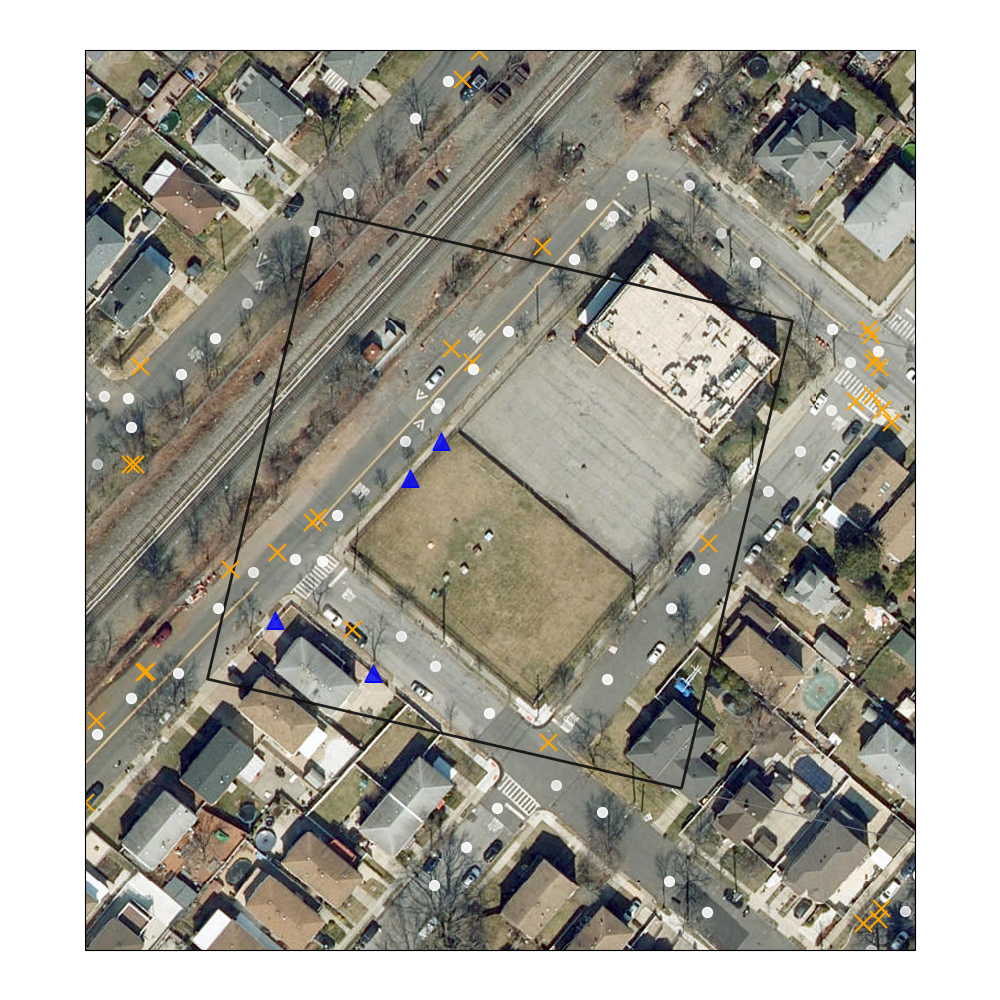

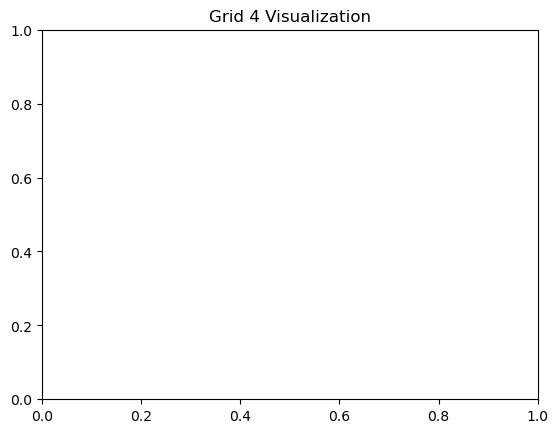

In [13]:
from eomaps import Maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import box
%matplotlib inline

# Select the specific grid index
grid_index = 4 
grid = sampled_grids_gdf.iloc[grid_index]  # Select the grid by index

# Extract the bounding box of the selected grid
grid_bbox = grid.geometry.bounds  # bounds = (minx, miny, maxx, maxy)
bbox = [
    grid_bbox[0] - 0.0003,  # minx with buffer
    grid_bbox[2] + 0.0003,  # maxx with buffer
    grid_bbox[1] - 0.0003,  # miny with buffer
    grid_bbox[3] + 0.0003   # maxy with buffer
]

# Create a map for the current grid
m = Maps(crs=Maps.CRS.Mercator.GOOGLE, figsize=(10, 10))
m.set_extent((bbox[0], bbox[1], bbox[2], bbox[3]))

# Add the grid as a highlighted bounding box
grid_bbox_poly = box(*grid_bbox)
m.add_gdf(sampled_grids_gdf, facecolor='none', edgecolor='grey', linewidth=1, alpha=0.8, label="Sampling Grids")
m.add_gdf(
    sampled_grids_gdf.loc[[grid_index]], facecolor='none', edgecolor='black', linewidth=2, alpha=0.8, label="Current Grid"
)

# Add geolocated trees, panos, and inventory trees
m.add_gdf(geolocated_trees_gdf, marker='x', color='orange', alpha=1, markersize=150, label='Geolocated Trees')
m.add_gdf(panos_gdf, marker='o', color='white', alpha=0.5, markersize=50, label='Panoramic Images')
m.add_gdf(tree_inventory_gdf, marker='^', color='blue', alpha=0.8, markersize=150, label='Tree Inventory')

# Add base layer
m.add_wms.ESRI_ArcGIS.SERVICES.World_Imagery.add_layer.xyz_layer()

# Display the map
plt.title(f"Grid {grid_index} Visualization")
m.show()


# Experiments with Greedy Genus Matching Tree Inventories and Predictions

In [14]:
# Greedy Genus Matching Between Tree Inventory and Geolocated Trees

In [15]:
# Adjusted code to perform nearest neighbor calculations for both matched and unmatched trees
def greedy_genus_matching_with_nn(tree_inventory_gdf, geolocated_trees_gdf, sampled_grids_gdf, max_distance=15):
    """
    Perform genus-prioritized greedy matching and calculate nearest neighbor distances for both matched and unmatched trees.
    Args:
        tree_inventory_gdf (gpd.GeoDataFrame): Ground truth tree locations with 'Genus' column.
        geolocated_trees_gdf (gpd.GeoDataFrame): Predicted tree locations with 'predicted_genus' column.
        sampled_grids_gdf (gpd.GeoDataFrame): Grids defining spatial sampling areas.
        max_distance (float): Maximum distance to consider a match as valid (in meters).
    Returns:
        list of dict: Matching results, including genus matches, distances, and nearest neighbors for all trees.
    """
    results = []

    def calculate_distance(p1, p2):
        return geodesic((p1.y, p1.x), (p2.y, p2.x)).meters

    # Iterate across sampling grids
    for _, grid_row in sampled_grids_gdf.iterrows():
        grid = grid_row.geometry
        grid_density_level = grid_row['density_level']
        
        # Subset tree inventory and predicted tree points by the density grid
        tree_inventory_in_grid = tree_inventory_gdf[tree_inventory_gdf.intersects(grid)]
        geolocated_trees_in_grid = geolocated_trees_gdf[geolocated_trees_gdf.intersects(grid)]
        panos_in_grid = panos_gdf[panos_gdf.intersects(grid)]

        # Skip grid if there are no geolocated trees in this grid
        if geolocated_trees_in_grid.empty:
            continue
        
        matches = []
        unmatched_trees = []
        genus_matches_count = 0
        neighbor_distances = []

        # Iterate across trees in the inventory
        for idx1, tree1 in tree_inventory_in_grid.iterrows():
            genus_match_tree = None
            genus_match_dist = float('inf')

            # Check for genus match within max distance
            for idx2, tree2 in geolocated_trees_in_grid.iterrows():
                dist = calculate_distance(tree1.geometry, tree2.geometry)
                if dist <= max_distance and tree1['genus'] == tree2['predicted_genus']:
                    if dist < genus_match_dist:
                        genus_match_dist = dist
                        genus_match_tree = idx2

            # Record matches and unmatched trees
            if genus_match_tree is not None:
                matches.append((idx1, genus_match_tree))
                geolocated_trees_in_grid = geolocated_trees_in_grid.drop(genus_match_tree)
                genus_matches_count += 1
            else:
                unmatched_trees.append(idx1)

            # Nearest neighbor analysis for this tree
            tree_coords = np.array([point.coords[0] for point in tree_inventory_in_grid.geometry])
            if len(tree_coords) > 1:
                kdtree = cKDTree(tree_coords)
                nn_distances, _ = kdtree.query(tree1.geometry.coords[0], k=len(tree_coords))
                nn_distances = nn_distances[1:] * 111132  # Exclude the tree itself and convert to meters

                neighbor_distances.append({
                    "inventory_tree_idx": idx1,
                    "is_matched": genus_match_tree is not None,
                    "matched_pred_tree_idx": genus_match_tree,
                    "genus_match_dist": None if genus_match_tree is None else genus_match_dist,
                    "genus_name": tree1['genus'],
                    "num_neighbors": len(nn_distances),
                    "neighbor_distances": nn_distances.tolist(),
                    "min_nn_distance": np.min(nn_distances),
                    "max_nn_distance": np.max(nn_distances),
                    "mean_nn_distance": np.mean(nn_distances),
                })


        results.append({
            "grid_id": grid_row.name,
            "grid_density_level": grid_density_level,
            "num_panos": len(np.unique(panos_in_grid['Pano_ID'])),
            "num_inv_trees": len(tree_inventory_in_grid),
            "num_genus_matches": genus_matches_count,
            "matches_idx": matches,
            "unmatched_tree_idx": unmatched_trees,
            "neighbor_distances": neighbor_distances,
        })

    return results

In [16]:
results = greedy_genus_matching_with_nn(tree_inventory_gdf, geolocated_trees_gdf, sampled_grids_gdf, max_distance=15)


In [17]:
# Examine single grid of matching results
results[3]

{'grid_id': 3,
 'grid_density_level': 'Low Density',
 'num_panos': 26,
 'num_inv_trees': 3,
 'num_genus_matches': 0,
 'matches_idx': [],
 'unmatched_tree_idx': [693, 3027, 4293],
 'neighbor_distances': [{'inventory_tree_idx': 693,
   'is_matched': False,
   'matched_pred_tree_idx': None,
   'genus_match_dist': None,
   'genus_name': 'liquidambar',
   'num_neighbors': 2,
   'neighbor_distances': [5.83416539383, 54.875019088061016],
   'min_nn_distance': 5.83416539383,
   'max_nn_distance': 54.875019088061016,
   'mean_nn_distance': 30.354592240945507},
  {'inventory_tree_idx': 3027,
   'is_matched': False,
   'matched_pred_tree_idx': None,
   'genus_match_dist': None,
   'genus_name': 'populus',
   'num_neighbors': 2,
   'neighbor_distances': [51.11165952328053, 54.875019088061016],
   'min_nn_distance': 51.11165952328053,
   'max_nn_distance': 54.875019088061016,
   'mean_nn_distance': 52.99333930567077},
  {'inventory_tree_idx': 4293,
   'is_matched': False,
   'matched_pred_tree_idx'

In [18]:
# Create an empty list to hold rows from all grids
all_data_rows = []

# Iterate through all grid results
for grid_result in results:
    for neighbor_info in grid_result['neighbor_distances']:
        # Create a row for each tree's neighbor analysis
        row = {
            'grid_id': grid_result['grid_id'],
            'grid_density_level': grid_result['grid_density_level'],
            'grid_num_panos': grid_result['num_panos'],
            'num_inv_trees': grid_result['num_inv_trees'],
            'num_genus_matches': grid_result['num_genus_matches'],
            'proportion_matches': grid_result['num_genus_matches'] / grid_result['num_inv_trees'],
            'inventory_tree_idx': neighbor_info['inventory_tree_idx'],
            'inventory_genus_name': neighbor_info['genus_name'],
            'is_matched': neighbor_info['is_matched'],
            'match_distance': neighbor_info['genus_match_dist'],
            'matched_pred_tree_idx': neighbor_info['matched_pred_tree_idx'],
            'min_nn_distance': neighbor_info['min_nn_distance'],
            'mean_nn_distance': neighbor_info['mean_nn_distance']
        }
        all_data_rows.append(row)

# Convert the collected rows into a DataFrame
df = pd.DataFrame(all_data_rows)

# Display the DataFrame
print(df)

# Optionally, save the DataFrame to a CSV for further analysis
#df.to_csv('tree_matching_results.csv', index=False)


      grid_id grid_density_level  grid_num_panos  num_inv_trees  \
0           0        Low Density              15              4   
1           0        Low Density              15              4   
2           0        Low Density              15              4   
3           0        Low Density              15              4   
4           1        Low Density              20              3   
...       ...                ...             ...            ...   
5901      626       High Density              25             17   
5902      626       High Density              25             17   
5903      626       High Density              25             17   
5904      626       High Density              25             17   
5905      626       High Density              25             17   

      num_genus_matches  proportion_matches  inventory_tree_idx  \
0                     0            0.000000                  47   
1                     0            0.000000                 5

In [19]:
# Analysis of Greedy Genus Matching Between Tree Inventory and Tree Predictions

C:\Users\talake2\AppData\Local\Temp\ipykernel_26292\98693401.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_matched', y='grid_num_panos', data=df, palette="Set2")


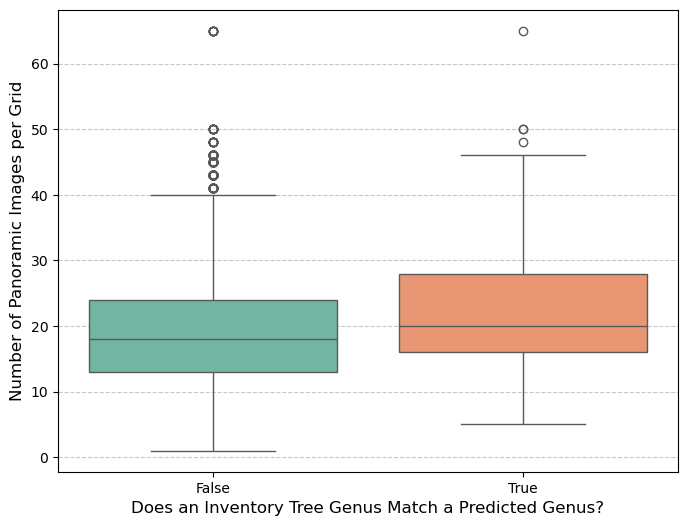

In [20]:
# Does Matching Tree Inventory to Predictions Depend on Number of Panoramic Images in a Grid?

# Create boxplots for 'is_matched' versus 'grid_num_panos'
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_matched', y='grid_num_panos', data=df, palette="Set2")

# Customize the plot
plt.xlabel("Does an Inventory Tree Genus Match a Predicted Genus?", fontsize=12)
plt.ylabel("Number of Panoramic Images per Grid", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [34]:
# Remove NA cases with no matches for plotting
df = df.dropna()

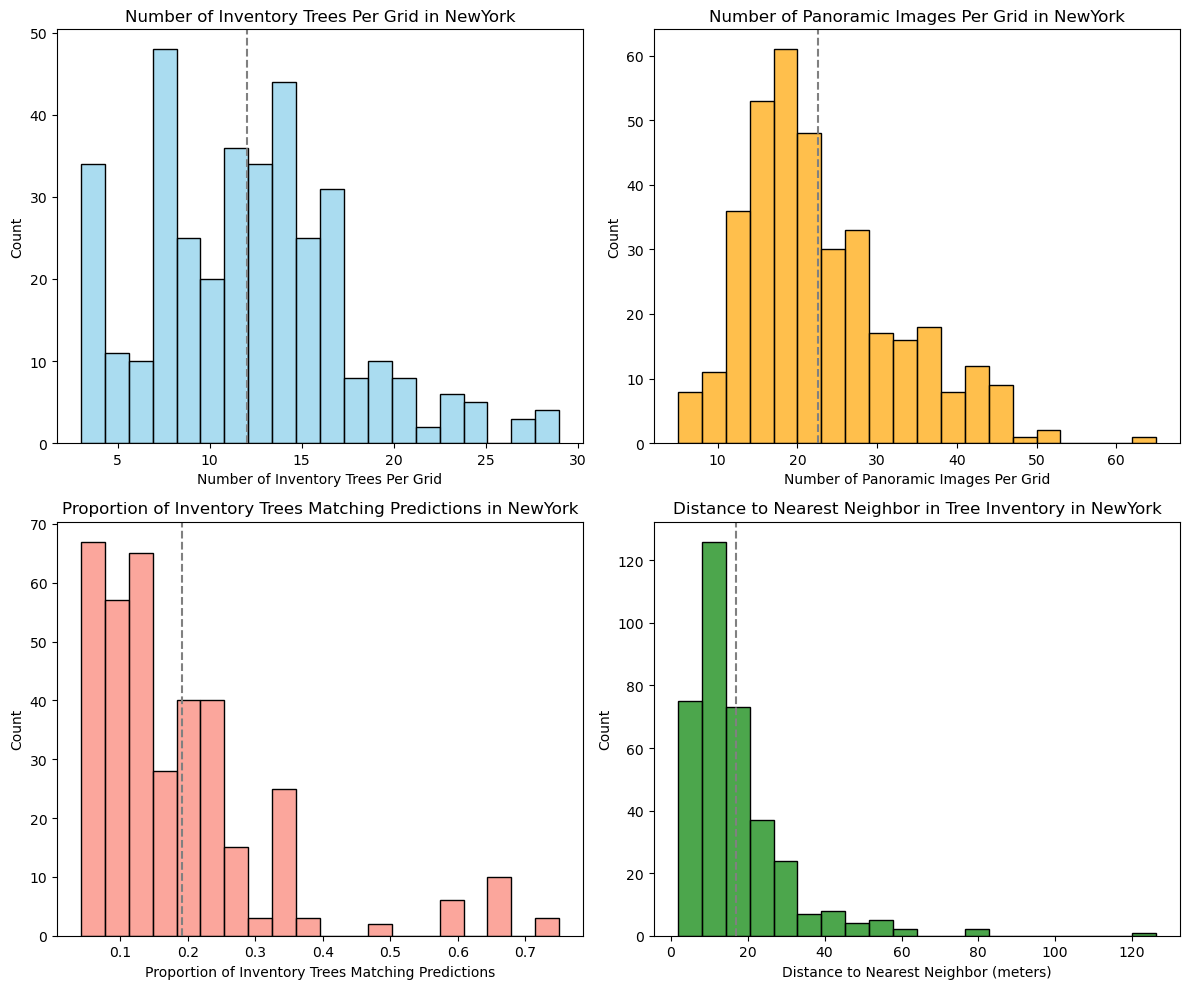

In [35]:
# Summary histograms

# Create a figure to contain the histograms
plt.figure(figsize=(12, 10))

# Plot histograms for each of the variables
plt.subplot(2, 2, 1)
sns.histplot(df['num_inv_trees'], kde=False, color='skyblue', bins=20, alpha=0.7)
plt.axvline(df['num_inv_trees'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Number of Inventory Trees Per Grid in {city}')
plt.xlabel('Number of Inventory Trees Per Grid')

plt.subplot(2, 2, 2)
sns.histplot(df['grid_num_panos'], kde=False, color='orange', bins=20, alpha=0.7)
plt.axvline(df['grid_num_panos'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Number of Panoramic Images Per Grid in {city}')
plt.xlabel('Number of Panoramic Images Per Grid')

plt.subplot(2, 2, 3)
sns.histplot(df['proportion_matches'], kde=False, color='salmon', bins=20, alpha=0.7)
plt.axvline(df['proportion_matches'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Proportion of Inventory Trees Matching Predictions in {city}')
plt.xlabel('Proportion of Inventory Trees Matching Predictions')

plt.subplot(2, 2, 4)
sns.histplot(df['min_nn_distance'], kde=False, color='green', bins=20, alpha=0.7)
plt.axvline(df['min_nn_distance'].mean(), color="grey", linestyle='--', label='Mean')
plt.title(f'Distance to Nearest Neighbor in Tree Inventory in {city}')
plt.xlabel('Distance to Nearest Neighbor (meters)')

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\talake2\AppData\Local\Temp\ipykernel_26292\3897074285.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grid_density_level', y='proportion_matches', data=df, palette="Set2")


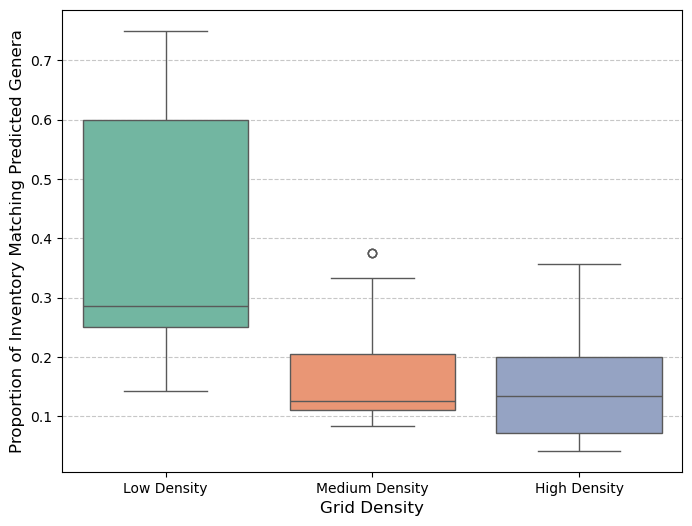

In [36]:

# Boxplots - Relationship between Inventory Tree Density and Proportion of Matches by Genus

plt.figure(figsize=(8, 6))
sns.boxplot(x='grid_density_level', y='proportion_matches', data=df, palette="Set2")

# Customize the plot
plt.xlabel("Grid Density", fontsize=12)
plt.ylabel("Proportion of Inventory Matching Predicted Genera", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

C:\Users\talake2\AppData\Local\Temp\ipykernel_26292\107122339.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grid_density_level', y='grid_num_panos', data=df, palette="Set2")


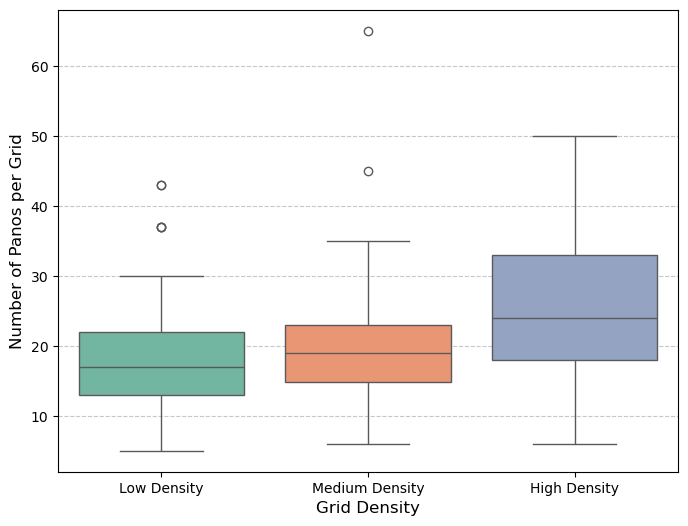

In [37]:

# Boxplots - Relationship between Grid Density and Num. Panos per Grid

plt.figure(figsize=(8, 6))
sns.boxplot(x='grid_density_level', y='grid_num_panos', data=df, palette="Set2")

# Customize the plot
plt.xlabel("Grid Density", fontsize=12)
plt.ylabel("Number of Panos per Grid", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

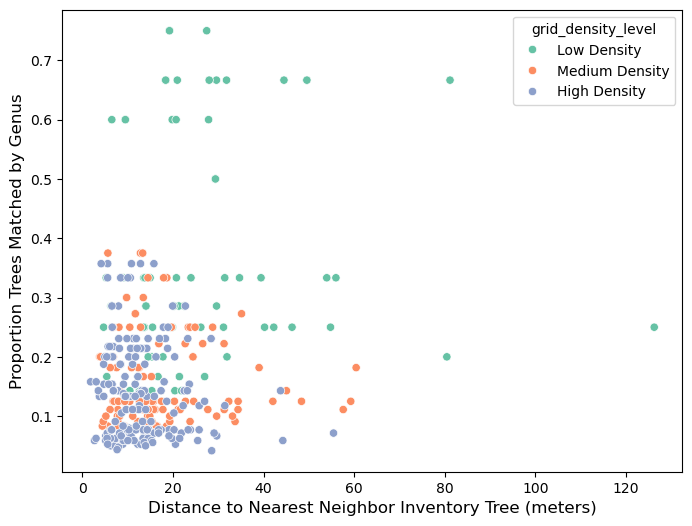

In [39]:

# Scatterplot - Relationship between Inventory Nearest Neighbor Distance and Proportion of Matches by Grid

plt.figure(figsize=(8, 6))
sns.scatterplot(x='min_nn_distance', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters)", fontsize=12)
plt.ylabel("Proportion Trees Matched by Genus", fontsize=12)

plt.show()

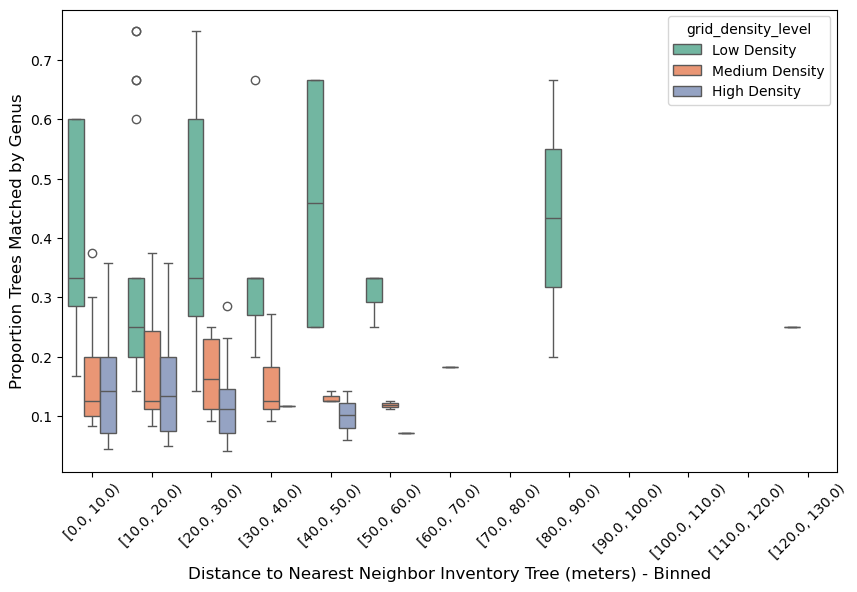

In [29]:
# Boxplots - Relationship between Inventory Nearest Neighbor Distance and Proportion of Matches by Grid

# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['min_nn_distance_bin'] = pd.cut(df['min_nn_distance'], bins=np.arange(0, df['min_nn_distance'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='min_nn_distance_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=12)
plt.ylabel("Proportion Trees Matched by Genus", fontsize=12)

plt.xticks(rotation=45)
plt.show()


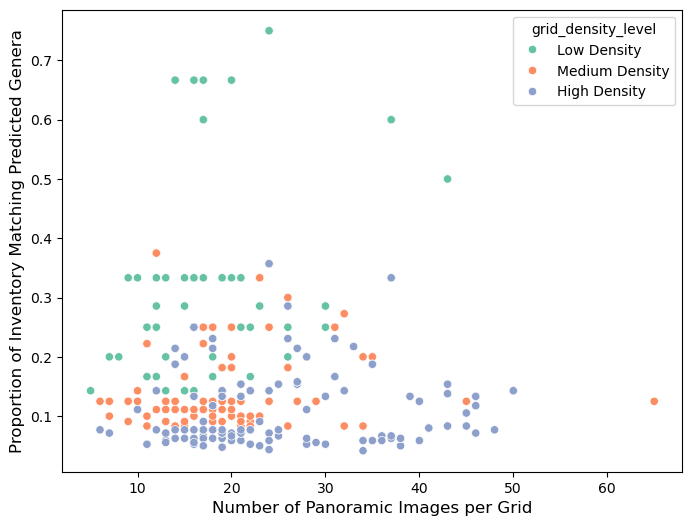

In [30]:

# Scatterplot - Relationship between Num. Panos per Grid and Proportion of Matches by Genus
plt.figure(figsize=(8, 6))
sns.scatterplot(x='grid_num_panos', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Number of Panoramic Images per Grid", fontsize=12)
plt.ylabel("Proportion of Inventory Matching Predicted Genera", fontsize=12)

plt.show()

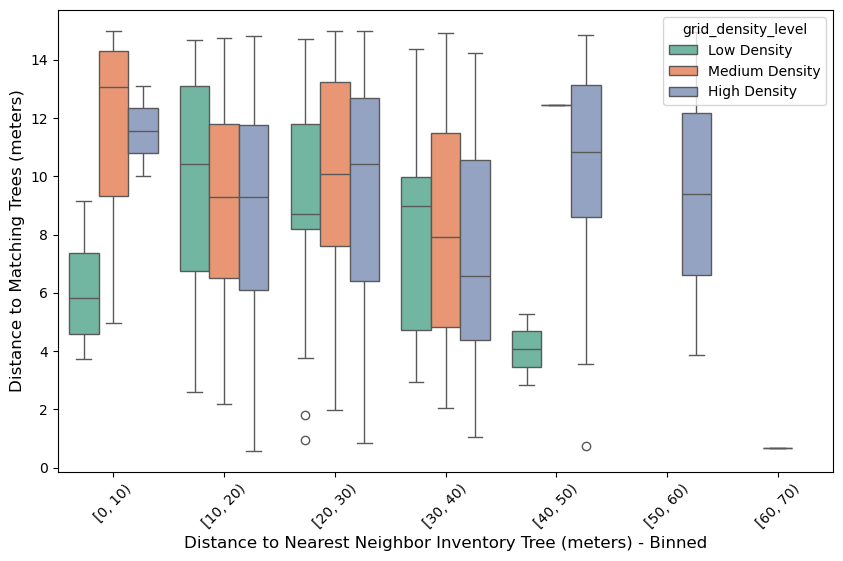

In [31]:
# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='grid_num_panos_bin', y='match_distance', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=12)
plt.ylabel("Distance to Matching Trees (meters)", fontsize=12)

plt.xticks(rotation=45)
plt.show()


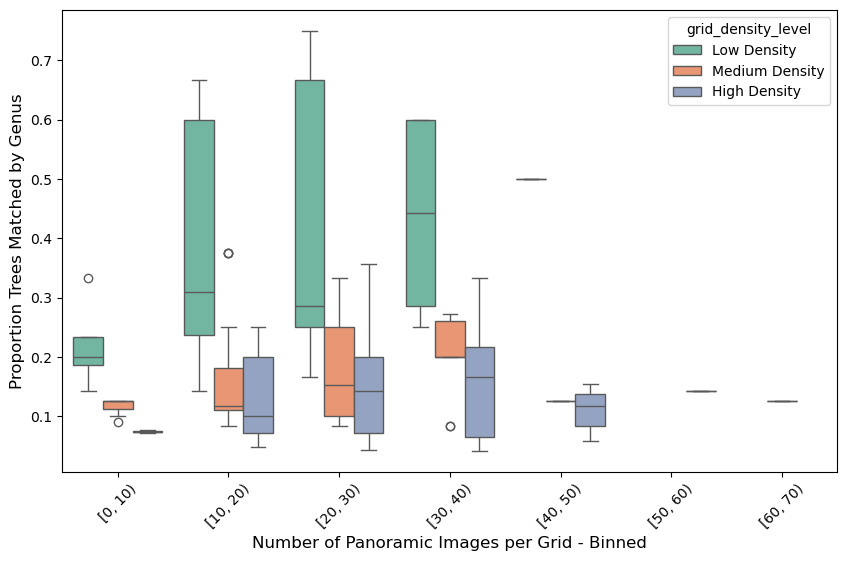

In [32]:
# Boxplots - Relationship between Num. Panos per Grid and Proportion of Matches by Genus

# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='grid_num_panos_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Number of Panoramic Images per Grid - Binned", fontsize=12)
plt.ylabel("Proportion Trees Matched by Genus", fontsize=12)

plt.xticks(rotation=45)
plt.show()


C:\Users\talake2\AppData\Local\Temp\ipykernel_26292\123788044.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


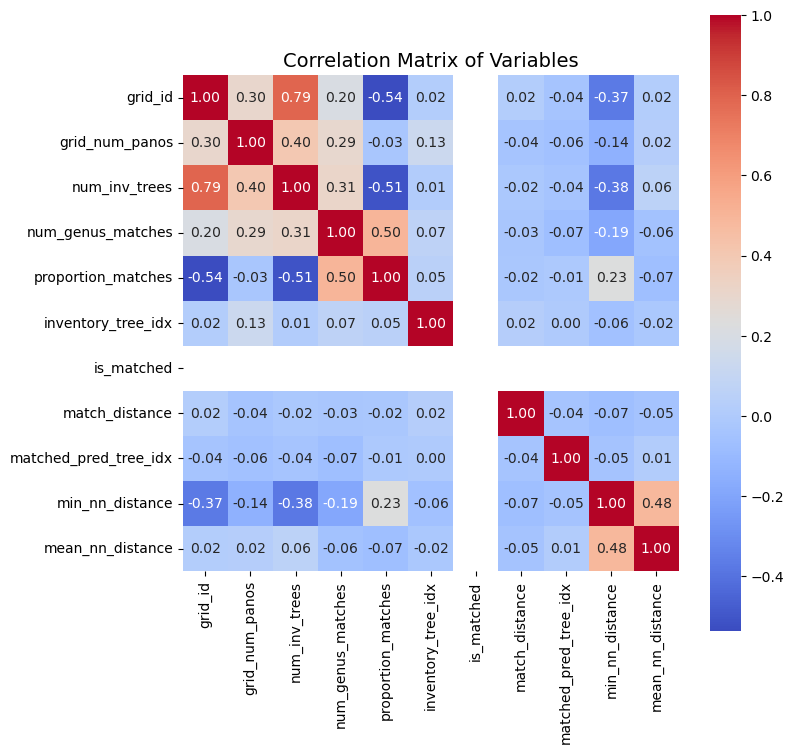

In [33]:
# Calculate the correlation matrix for the numeric variables in `all_data_table`
correlation_matrix = df.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)

# Customize the heatmap
plt.title("Correlation Matrix of Variables", fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)

plt.show()


In [ ]:
# EOF